In [130]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta # for technical analysis
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import random
import matplotlib.colors as mcolors

In [105]:
# Define main variables. We will use the Nasdaq-100 to create our portafolio
link = "https://en.wikipedia.org/wiki/Nasdaq-100"
end_date = datetime.strptime('2023-12-31', "%Y-%m-%d")
start_date = end_date - timedelta(days=365*5)

In [106]:
def get_index_components_from_html(link:str, start_date:str, end_date:str) -> pd.DataFrame:
    """Get all components of a market index

    Args:
        link (str): link that have all components of market index
        start_date (str): Download start date string (YYYY-MM-DD)
        end_date (str): Download end date string (YYYY-MM-DD)

    Returns:
        pd.DataFrame: dataframe with information of each component
    """
    components = pd.read_html(link)[4]
    tickers = components["Ticker"].unique().tolist()
    data = yf.download(tickers,start=start_date, end=end_date).stack()
    data.index.names = ["Date", "Ticker"]
    return data

In [107]:
# Get data from Nasdaq-100
data = get_index_components_from_html(link,start_date, end_date)
original_colums = data.columns

[*********************100%%**********************]  101 of 101 completed
C:\Users\omare\AppData\Local\Temp\ipykernel_14708\3202423078.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data = yf.download(tickers,start=start_date, end=end_date).stack()


## Calculate technical indicators

### 1. Garman-Klass Volatility
Medida utilizada para evaliar la volatividad de un activo financiero. Si el valor numérico de la volatilidad Garman-Klass es del 15%, significa que, en promedio, se espera que el precio del activo fluctúe en un rango del 15% en relación con su precio medio durante el período de tiempo analizado.

In [108]:
def get_garman_klass(data:pd.DataFrame):
    """Calculate Garman-Klass volatility

    Args:
        data (pd.DataFrame): dataframe with stock data (Open, High, Low, Close)
    """
    return ((np.log(data["High"]) - np.log(data["Low"]))**2)/2 - (2*np.log(2)-1)*((np.log(data['Close'])-np.log(data['Open']))**2)

### 2. RSI - Relative Strength Index
Indicador de momentum que mide la magnitud de los movimientos de precios para determinar las condiciones de sobrecompra o sobreventa de un activo [0, 100].
Cuando el RSI está por encima de 70, se considera que el activo está sobrecomprado. Por otro lado, cuando el RSI está por debajo de 30, se considera que el activo está sobrevendido.

In [109]:
def get_rsi(data:pd.DataFrame):
    """Calculate Garman-Klass volatility

    Args:
        data (pd.DataFrame): dataframe with stock data (Close)
    """
    return data.groupby(level="Ticker")['Close'].transform(lambda x: pandas_ta.rsi(close=x,length=25))

### 3. MACD - Moving Average Convergence Divergence
Indicador para identificar cambios en la fuerza, dirección, impulso y duración de una tendencia en el precio de un activo. Este indicador se compone de dos líneas principales: la línea MACD y la línea de señal. 
La Línea MACD es la diferencia entre dos medias móviles exponenciales (EMAs): una de 12 días y otra de 26 días.
La línea de señal es una EMA de 9 días de la línea MACD.

Interpretación numérica:

**Cruce de Líneas**: Los cruces entre la Línea MACD y la Línea de Señal pueden indicar posibles señales de compra o venta. Cuando la Línea MACD cruza por encima de la Línea de Señal, puede interpretarse como una señal alcista, mientras que un cruce por debajo puede interpretarse como una señal bajista.

**Histograma**: Los valores del histograma MACD, ya sea por encima o por debajo de cero, indican la fuerza y ​​la dirección de la tendencia. Valores positivos sugieren una tendencia alcista, mientras que valores negativos sugieren una tendencia bajista.

In [110]:
def compute_MACD(close):
    """Compute MACD from close prices"""
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

def get_MACD(data:pd.DataFrame):
    """Calculate MACD indicator

    Args:
        data (pd.DataFrame): dataframe with stock data (Close)
    """
    return data.groupby(level="Ticker", group_keys=False)['Close'].apply(compute_MACD)

### 4. Bollinger Bands
Estas bandas son un tipo de envelope que se colocan alrededor del precio de un activo y están formadas por tres líneas:

**Línea Central (Media Móvil Simple)**: La línea central es una media móvil simple (SMA) que generalmente se calcula utilizando el precio de cierre durante un período específico. El valor predeterminado suele ser una SMA de 20 periodos.

**Banda Superior (Upper Band)**: Esta banda se encuentra por encima de la línea central y generalmente se calcula sumando dos desviaciones estándar al precio de la SMA.

**Banda Inferior (Lower Band)**: Esta banda se encuentra por debajo de la línea central y se calcula restando dos desviaciones estándar al precio de la SMA.

Interpretación de las Bandas de Bollinger:

**Rangos de Precios Esperados**: Las bandas superiores e inferiores actúan como niveles de resistencia y soporte dinámicos. 

**Volatilidad**: Cuando las bandas están más separadas, indica mayor volatilidad en el mercado.

**Cruces**: Los cruces de precios de un extremo a otro de las bandas pueden indicar posibles cambios de tendencia. Por ejemplo, si el precio cruza la banda superior, podría sugerir condiciones de sobrecompra, mientras que un cruce por debajo de la banda inferior podría indicar condiciones de sobreventa.

**Divergencias**: Divergencias entre el precio y las Bandas de Bollinger pueden ser señales de posibles cambios en la dirección del precio.

In [111]:
def get_bollinger_bands(data:pd.DataFrame) -> pd.DataFrame:
    """Calculate Bollinger Bands

    Args:
        data (pd.DataFrame): dataframe with stock data (Close)
    """
    
    bb_low = data.groupby(level=1)['Close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])                                                  
    bb_mid = data.groupby(level=1)['Close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
    bb_high = data.groupby(level=1)['Close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

    return pd.DataFrame({"bb_low":bb_low, "bb_mid":bb_mid, "bb_high":bb_high})

### 5. ATR - Average True Range
Medir la volatilidad de un activo financiero.

Mayor ATR: Indica mayor volatilidad en el mercado, lo que puede ser útil para operadores que buscan aprovechar movimientos significativos de precios.

Menor ATR: Indica menor volatilidad, lo que podría ser de interés para aquellos que prefieren mercados más estables y predecibles.

In [112]:
def compute_ATR(stock_data):
    """Compute ATR from stock data (High, Low, Close) s"""
    atr = pandas_ta.atr(high=stock_data['High'],
                        low=stock_data['Low'],
                        close=stock_data['Close'],
                        length=14)
    
    return  atr.sub(atr.mean()).div(atr.std())

def get_ATR(data:pd.DataFrame):
    """Calculate ATR indicator

    Args:
        data (pd.DataFrame): dataframe with stock data (High, Low, Close)
    """
    return data.groupby(level="Ticker", group_keys=False).apply(compute_ATR)

### 6. Dollar volumen - Average True Range
Es una medida que combina el número de acciones o contratos negociados con el precio de esos activos en un periodo de tiempo específico.

In [113]:
def get_dollar_volume(data:pd.DataFrame):
    """Calculate Dollar Volume

    Args:
        data (pd.DataFrame): dataframe with stock data (Close, Volume)
    """
    return data['Close'].mul(data['Volume'])/1e6

Save all indicators into the data frame

In [114]:
# Get all indicators
data['Garman-Klass'] = get_garman_klass(data)
data['RSI'] = get_rsi(data)
data['MACD'] = get_MACD(data)

# Concatenate bollinger bands to the dataframe
data = pd.concat([data, get_bollinger_bands(data)], axis=1)

data['ATR'] = get_ATR(data)
data['Dollar Volume'] = get_dollar_volume(data)

Filter most liquid stocks by dollar volume and get the best 50 stocks to trade.

In [115]:
def get_most_liquid_stocks(data, n=50, time_indicator = "M"):
    
    dolar_volume = data.unstack("Ticker")["Dollar Volume"].resample(time_indicator).mean().stack("Ticker").to_frame("Dollar Volume")
    
    # Select just indicator columns
    indicators = list(set(data.columns) - set(original_colums) - set(["Dollar Volume"]))
    indicators.append("Close")
    indicators_period = data.unstack()[indicators].resample(time_indicator).last().stack("Ticker")
    
    data = pd.concat([dolar_volume, indicators_period], axis=1).dropna()
    
    # Filter based on the year rolling avg of dollar volume
    data["Dollar Volume"] = data["Dollar Volume"].unstack("Ticker").rolling(12).mean().stack()
    data["Dollar Volumen Rank"] = (data.groupby('Date')['Dollar Volume'].rank(ascending=False))
    data = data[data["Dollar Volumen Rank"]<n].drop(['Dollar Volume', 'Dollar Volumen Rank'], axis=1) 
    
    return data

In [116]:
# Get the most liquid stocks
data = get_most_liquid_stocks(data)

C:\Users\omare\AppData\Local\Temp\ipykernel_14708\229955073.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dolar_volume = data.unstack("Ticker")["Dollar Volume"].resample(time_indicator).mean().stack("Ticker").to_frame("Dollar Volume")
C:\Users\omare\AppData\Local\Temp\ipykernel_14708\229955073.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  indicators_period = data.unstack()[indicators].resample(time_indicator).last().stack("Ticker")
C:\Users\omare\AppData\Local\Temp\ipykernel_14708\229955073.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  indicators_period = data.unstack()[indicators].resample(time_indicator).last().stack("Ticker")


Calculate Returns for different time periods as features.

In [117]:
def clip_quatile(data: pd.DataFrame, outlier = 0.01):
    """Get the data clipped by quantile"""
    return data.clip(lower=data.quantile(outlier), upper= data.quantile(1-outlier))

# Calculate retuns
def calculate_returns(df):
    """Calculate montly returns over lags.

    Args:
        df (DataFrame): Input DataFrame containing financial data.

    Returns:
        DataFrame: Original DataFrame with additional columns for returns calculated over specified time lags.
    """
    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        # Formula: return = (1+ptc)**period - 1
        df[f'return_{lag}m'] = df['Close'].pct_change(lag).pipe(clip_quatile).add(1).pow(1/lag).sub(1)
    return df


In [118]:
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

### Fama-French Factors
Este modelo se utiliza para explicar las diferencias en las rentabilidades de las carteras y de los activos. 
El modelo de 5 factores de Fama-French ha sido ampliamente aceptado y utilizado en el análisis financiero para evaluar el rendimiento de las carteras de inversión y para el diseño de estrategias de inversión.


We want to use this factors to estimate the exposure of assets to common risk factors using linear regression.

In [119]:
def get_fama_factors(data, sample_period = "M", filter_period = 12):
    factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3','famafrench', start='2012')[0].drop("RF", axis=1)
    factor_data.index = factor_data.index.to_timestamp()
    factor_data = factor_data.resample(sample_period).last().div(100) #Resample by last day of the month and showing data in percentage
    factor_data = factor_data.join(data['return_1m'])

    # Filter out stocks with less than filter_period 
    stock_obs = factor_data.groupby(level=1).size()
    filter_stocks = stock_obs[stock_obs >= filter_period]
    factor_data = factor_data[factor_data.index.get_level_values('Ticker').isin(filter_stocks.index)]
    
    return factor_data

Calculate Rolling Factor Betas

A beta of 1 indicates that the stock tends to move in line with the market, while a beta greater than 1 suggests the stock is more volatile than the market, and a beta less than 1 indicates lower volatility than the market.

The Beta coefficient is a measure of sensitivity or correlation of a security or an investment portfolio to movements in the overall market.

Ordinary least squares (OLS) is a type of linear least squares method for choosing the unknown parameters in a linear regression model


In [120]:
def calculate_rollingOLS(data):
    """ Calculate rolling OLS for the stoks returns over 1 month
    We define a window of 24 months and a minimum number of observations
    We also want to return just the beta coefficient without other details of the model
    
    """
    result = RollingOLS(endog=data['return_1m'], exog=sm.add_constant(data.drop('return_1m', axis=1)),window=min(24, data.shape[0]),min_nobs=len(data.columns)+1).fit(params_only=True).params.drop('const', axis=1)
    return result

def get_rolling_beta(factor_data):
    """Calculate rolling beta

    Args:
        data (pd.DataFrame): dataframe with stock data (Close)
        window (int): rolling window

    Returns:
        pd.DataFrame: dataframe with rolling beta
    """
    # Calculate rolling beta
    rolling_beta = (factor_data.groupby(level=1,group_keys=False).apply(calculate_rollingOLS))
    return rolling_beta

Calculate Rolling Factor Betas and join them to the main dataframe

In [121]:
# Get betas from fama factors
factors_data = get_fama_factors(data)
betas = get_rolling_beta(factors_data)

# Merge betas with the original data
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data = (data.join(betas.groupby('Ticker').shift()))
data.loc[:, factors] = data.groupby('Ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.drop('Close', axis=1)
data = data.dropna()

C:\Users\omare\AppData\Local\Temp\ipykernel_14708\4261127703.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3','famafrench', start='2012')[0].drop("RF", axis=1)
C:\Users\omare\AppData\Local\Temp\ipykernel_14708\4261127703.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3','famafrench', start='2012')[0].drop("RF", axis=1)
C:\Users\omare\AppData\Local\Temp\ipykernel_14708\4261127703.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  factor_data = factor_data.resample(sample_period).last().div(100) #Res

### K-means clustering
We are going to use K-means clustering to group stocks based on their features.
This will help us to identify stocks that are similar to each other and to find the best stocks to trade.


In K-means clustering, the initial centroids are the starting points for the algorithm's iterations. They represent the initial guesses for the cluster centers around which the algorithm will attempt to group the data points. We will use in this case a K-means++ Initialization, which is a smart initialization technique that selects the initial cluster centers to speed up the convergence of the algorithm.



In [122]:
# Define initial centroids base on the target RSI values
target_rsi_values = [30, 45, 55, 70]

# Dimension base on the number of featrues
initial_centroids = np.zeros((len(target_rsi_values), len(data.columns)))
initial_centroids[:, 6] = target_rsi_values

n_clusters = initial_centroids.shape[0]

In [123]:
def get_clusters(data, initial_centroids, n_clusters = 5, random_state = 0):  
    data["cluster"] = KMeans(n_clusters=n_clusters, random_state=random_state, init=initial_centroids).fit(data).labels_
    return data

In [125]:
# Apply the clustering algorithm and save clusters in the original dataframe
data = data.dropna().groupby('Date', group_keys=False).apply(get_clusters, initial_centroids=initial_centroids, n_clusters=n_clusters)

bb_mid       ATR      MACD  Garman-Klass    bb_low  \
Date       Ticker                                                         
2021-01-31 AAPL    4.897257  0.997129  0.826281      0.000874  4.821276   
           ADBE    6.159311 -0.060946 -0.702860      0.000210  6.114381   
           AMAT    4.607654  0.369218  1.306323      0.000496  4.463929   
           AMD     4.528647  0.094829 -0.459392      0.000539  4.464965   
           AMGN    5.494611  1.529500  1.367479      0.000247  5.416450   
...                     ...       ...       ...           ...       ...   
2023-12-31 REGN    6.747403  0.207666  1.012061      0.000038  6.702658   
           SBUX    4.581764 -0.778561 -0.742562      0.000054  4.557137   
           TMUS    5.059493 -0.451996  1.102940      0.000090  5.031128   
           TSLA    5.513506 -0.001970  0.421762      0.000210  5.451598   
           TXN     5.104751 -0.879477  1.818825      0.000039  5.033835   

                    bb_high        RSI  return_1m  return_2m  return_3m  \
Date       Ticker                                                         
2021-01-31 AAPL    4.973238  52.690965  -0.005502   0.052826   0.066247   
           ADBE    6.204241  44.182560  -0.082680  -0.020803   0.008626   
           AMAT    4.751380  55.571553   0.120278   0.082665   0.168445   
           AMD     4.592328  44.707044  -0.066187  -0.038626   0.043870   
           AMGN    5.572771  52.823984   0.050061   0.042750   0.036296   
...                     ...        ...        ...        ...        ...   
2023-12-31 REGN    6.792147  62.600902   0.066132   0.061212   0.021927   
           SBUX    4.606392  45.973582  -0.033132   0.020231   0.017020   
           TMUS    5.087858  68.890783   0.065670   0.055692   0.046110   
           TSLA    5.575414  52.532771   0.034988   0.112297  -0.002323   
           TXN     5.175667  62.775274   0.116233   0.093110   0.023449   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
Date       Ticker                                                         
2021-01-31 AAPL     0.036761   0.067265    0.045488  1.198396 -0.299408   
           ADBE     0.005348   0.029341    0.022530  1.575603 -0.958485   
           AMAT     0.070255   0.076783    0.043515  1.581087  0.406331   
           AMD      0.016938   0.056122    0.051272  1.712540 -0.598849   
           AMGN    -0.002219   0.001022    0.009299  0.806441  0.009887   
...                      ...        ...         ...       ...       ...   
2023-12-31 REGN     0.034025   0.007432    0.016523  0.551427 -0.499554   
           SBUX    -0.005199  -0.008980   -0.002720  0.949044  0.292022   
           TMUS     0.024202   0.011353    0.011363  0.530541  0.649745   
           TSLA    -0.008646   0.020249    0.060220  1.548772  0.297188   
           TXN     -0.009053  -0.009653    0.002605  1.135273 -0.435341   

                        HML       RMW       CMA  cluster  
Date       Ticker                                         
2021-01-31 AAPL   -0.291584  0.158374 -0.068095        2  
           ADBE    0.118145  0.058522 -0.460213        1  
           AMAT    0.237200  0.875584 -0.483024        2  
           AMD    -0.181815  1.074035 -1.144928        1  
           AMGN    0.044548  0.318908  0.963615        2  
...                     ...       ...       ...      ...  
2023-12-31 REGN   -0.645133 -0.544431  0.824321        3  
           SBUX   -0.494126  0.600359  0.432589        1  
           TMUS   -0.096881  0.136054  0.370134        0  
           TSLA    0.441793 -1.902531 -2.655547        2  
           TXN     0.057507 -0.148058 -0.208044        3  

[1387 rows x 19 columns]

Create a function to plot the clusters

In [136]:
def get_scatter_colors(n):
    """This function will return a list of n colors from the CSS4 color palette"""
    color_names = list(mcolors.CSS4_COLORS.keys())
    return random.sample(color_names, n)

In [146]:
def plot_clusters(data, n_clusters, colors):
    """This function will plot the clusters in a scatter plot using the rsi and atr indicators"""
    if n_clusters is None: return 
    if len(colors) !=  n_clusters: return

    for i in range(n_clusters):
        cluster = data[data['cluster']==i]
        plt.scatter(cluster['RSI'], cluster['ATR'], color=colors[i], label=f'Cluster {i}')

    plt.legend()
    plt.show()
    return

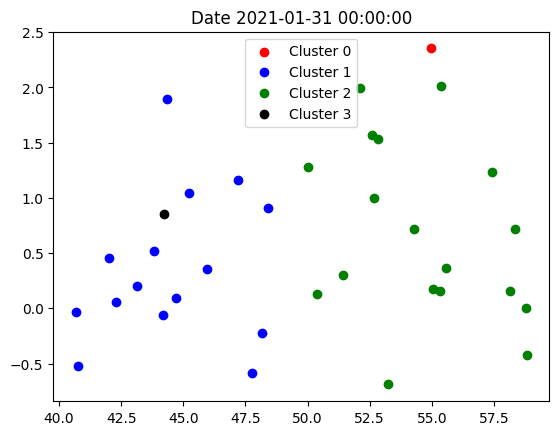

In [151]:
# Plot the clusters in the RSI vs Garman-Klass volatility space
colors = ['red', 'blue', 'green', 'black']

for i in data.index.get_level_values('Date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')    
    plot_clusters(g, n_clusters, colors)
    break

### Create portafolio

Create a portafolio for n period of time based on cluster and Efficient Frontier max sharpe ratio

The Efficient Frontier in finance refers to a set of optimal portfolios that offer the highest expected return for a given level of risk or the lowest risk for a given level of expected return.
At this point we have to identify what is the best cluster by looking at the rsi values

In [160]:
def create_portafolio(data, cluster):
    filtered_df = data[data['cluster']==cluster].copy()
    filtered_df = filtered_df.reset_index(level=1)
    filtered_df.index = filtered_df.index+pd.DateOffset(1)
    filtered_df = filtered_df.reset_index().set_index(['Date', 'Ticker'])
    dates = filtered_df.index.get_level_values('Date').unique().tolist()
    fixed_dates = {}
    for d in dates:
        fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    return fixed_dates

In [161]:
portafolio = create_portafolio(data, 3)

In [163]:
portafolio

{'2021-02-01': ['BKNG'],
 '2021-03-01': ['BKNG'],
 '2021-04-01': ['AMAT', 'CSCO', 'TXN'],
 '2021-05-01': ['AMZN', 'CHTR', 'COST', 'GOOG', 'GOOGL', 'ISRG', 'META'],
 '2021-06-01': ['MDLZ'],
 '2021-07-01': ['ADBE',
  'AMD',
  'INTU',
  'ISRG',
  'LULU',
  'MRNA',
  'MSFT',
  'NVDA',
  'PYPL',
  'REGN'],
 '2021-08-01': ['ADBE',
  'AMD',
  'COST',
  'GOOGL',
  'INTU',
  'ISRG',
  'LULU',
  'MRNA',
  'MSFT',
  'PEP'],
 '2021-09-01': ['ADBE',
  'CHTR',
  'COST',
  'CSCO',
  'GOOG',
  'GOOGL',
  'INTU',
  'ISRG',
  'NFLX',
  'REGN'],
 '2021-10-01': ['NFLX', 'TSLA'],
 '2021-11-01': ['COST', 'INTU', 'LULU', 'MSFT', 'NFLX', 'NVDA', 'TSLA'],
 '2021-12-01': ['AAPL', 'AMD', 'COST', 'LRCX', 'MU', 'NVDA', 'QCOM', 'TSLA'],
 '2022-01-01': ['AAPL',
  'AMGN',
  'AVGO',
  'COST',
  'CSCO',
  'GILD',
  'LRCX',
  'MU',
  'PEP',
  'QCOM'],
 '2022-02-01': ['BKNG'],
 '2022-03-01': ['ADBE', 'BKNG', 'INTU', 'MRNA', 'NFLX', 'SBUX'],
 '2022-04-01': ['AMGN', 'COST', 'CRWD', 'REGN', 'TSLA'],
 '2022-05-01': ['AAPL',
